# Interactive Demo for Fors2 with Photometry only to Read results



- author (adaptation) : Sylvie Dagoret-Campagne
- creation date : 2023-06-15
- last update : 2023-06-15


https://github.com/bd-j/prospector/blob/main/demo/tutorial.rst

# Visualizing the Results
There are a few basic plotting tools available to do a quick check on the results available in `prospect.io.read_results` and `prospect.utils.plotting`. But first we need to read the output files we made.

## Reading output files
Reading our results from our HDF5 file is straightforward using the `results_from` method.  This returns a "results" dictionary, the `obs` dictionary of data to which the model was fit, and in some situations the `SedModel` object that was used in the fitting.

In this example we will look at the *emcee* results file that we created, but you can do the same for the *dynesty* results file.  The main difference is that the chains for each fit type have a different dimensionality, and that the samples in the *dynesty* chains come with associated **weights**.  The weights and different shapes are handled automatically by the plotting functions included in *prospector*, but custom plotting code should take care of the difference.

In this notebook we have already defined the `model` (and `sps`) object, but in general one will want to recreate it.  *Prospector* allows you to do this by storing the `build_model` and `build_sps` code as text in the HDF5 file -- this is possible with the use of *parameter files* and command line operation.

In [1]:
import numpy as np

In [2]:
!ls output

demo_dynesty_mcmc_SPEC214_photomonly_23Jun15-15.04.h5
demo_emcee_mcmc_SPEC214_photomonly_23Jun15-14.52.h5
demo_emcee_mcmc_SPEC214_spectrophotom_23Jun15-15.28.h5
run_optimize_SPEC214_photom_23Jun15-14.48_result.h5
run_optimize_SPEC214_photom_23Jun15-14.54_result.h5
run_optimize_dynesty_SPEC214_photom_23Jun15-15.06_result.h5
run_optimize_dynesty_SPEC214_spectrophotom_23Jun15-17.07_result.h5
run_optimize_emcee_SPEC214_photom_23Jun15-14.58_result.h5
run_optimize_emcee_SPEC214_spectrophotom_23Jun15-16.59_result.h5


In [3]:
filename = "output/run_optimize_emcee_SPEC214_photom_23Jun15-14.58_result.h5"

In [10]:
import prospect.io.read_results as reader
results_type = "emcee" # | "dynesty"
# grab results (dictionary), the obs dictionary, and our corresponding models
# When using parameter files set `dangerous=True`
result, obs, model = reader.results_from(filename, dangerous=False)

#The following commented lines reconstruct the model and sps object, 
# if a parameter file continaing the `build_*` methods was saved along with the results
model = reader.get_model(result)
sps = reader.get_sps(result)

# let's look at what's stored in the `result` dictionary
print(result.keys())

dict_keys(['model_params', 'optimizer_duration', 'paramfile_text', 'prospector_version', 'run_params', 'acceptance', 'chain', 'initial_theta', 'lnprobability', 'sampling_initial_center', 'rstate', 'sampling_duration', 'theta_labels', 'bestfit', 'optimization', 'obs', 'model'])


In [11]:
result['bestfit']

{'parameter': array([ 9.52306226e+09, -5.95132208e-01,  1.93712402e+00,  4.69378615e-01,
         5.35105595e-01]),
 'photometry': array([1.71963878e-10, 6.67852146e-10, 1.73315903e-09, 3.43759838e-09,
        6.68727687e-09, 8.49462844e-09, 1.01173718e-08, 1.53130046e-08,
        1.86444820e-08, 2.21252549e-08]),
 'restframe_wavelengths': array([9.100e+01, 9.400e+01, 9.600e+01, ..., 9.817e+07, 9.908e+07,
        1.000e+08]),
 'spectrum': array([7.20531924e-28, 1.70154254e-27, 3.15262543e-27, ...,
        7.15180932e-10, 6.96257916e-10, 6.78303029e-10]),
 'mfrac': 0.7747327394600355}

## Plotting parameter traces
To see how our MCMC samples look, we can examine a few traces (that is, the evolution of the parameter value with iteration in the MCMC chain.)  You can use these plots (and the chains more generally) to assess whether the MCMC has converged, or if you need to sample for more iterations.

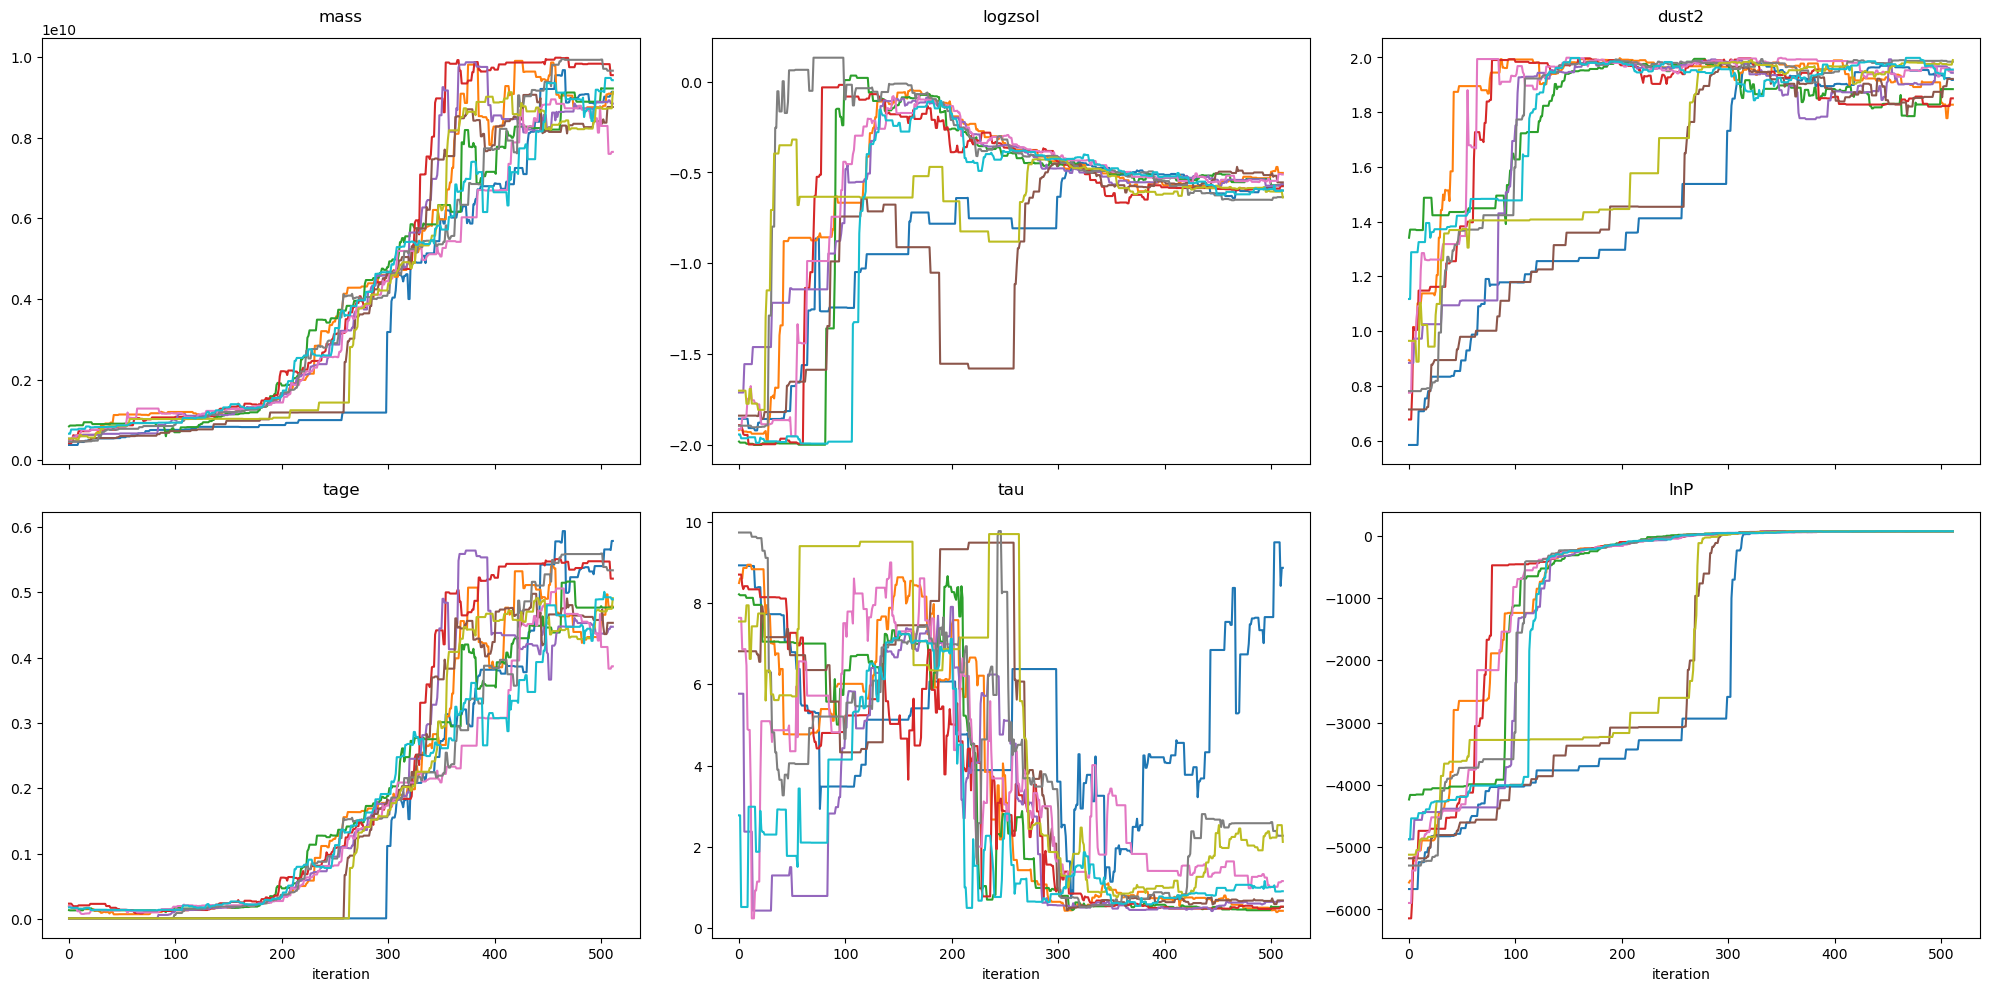

In [12]:
if results_type == "emcee":
    chosen = np.random.choice(result["run_params"]["nwalkers"], size=10, replace=False)
    tracefig = reader.traceplot(result, figsize=(20,10), chains=chosen)
else:
    tracefig = reader.traceplot(result, figsize=(20,10))


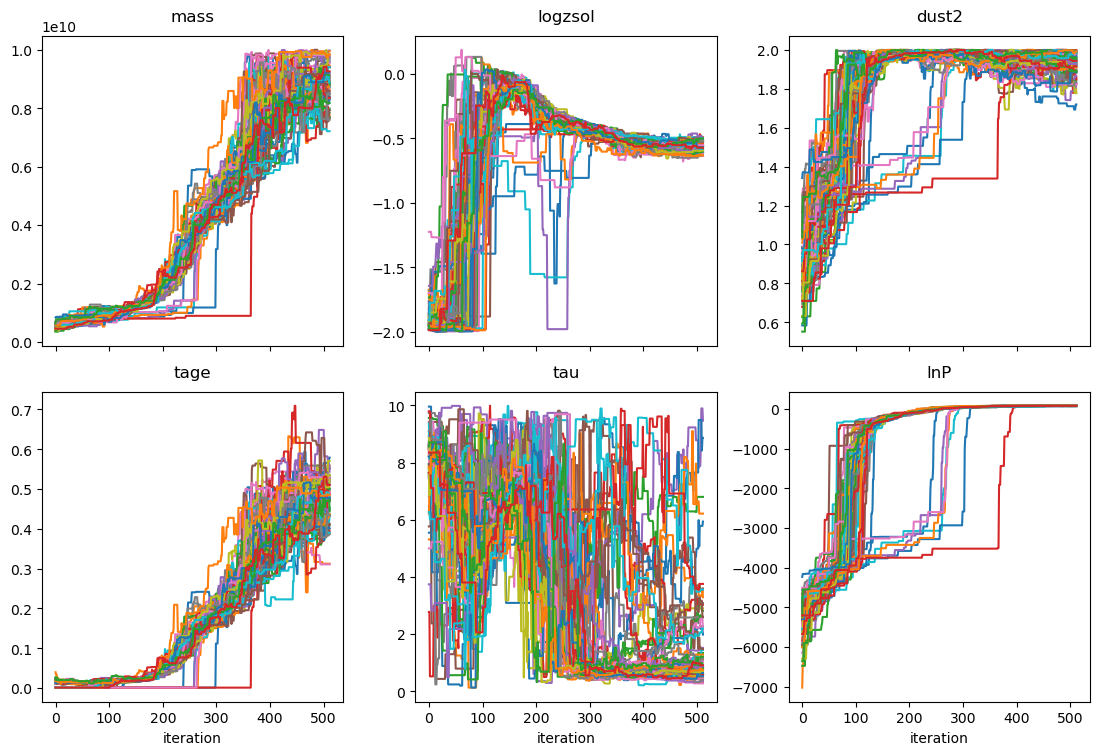

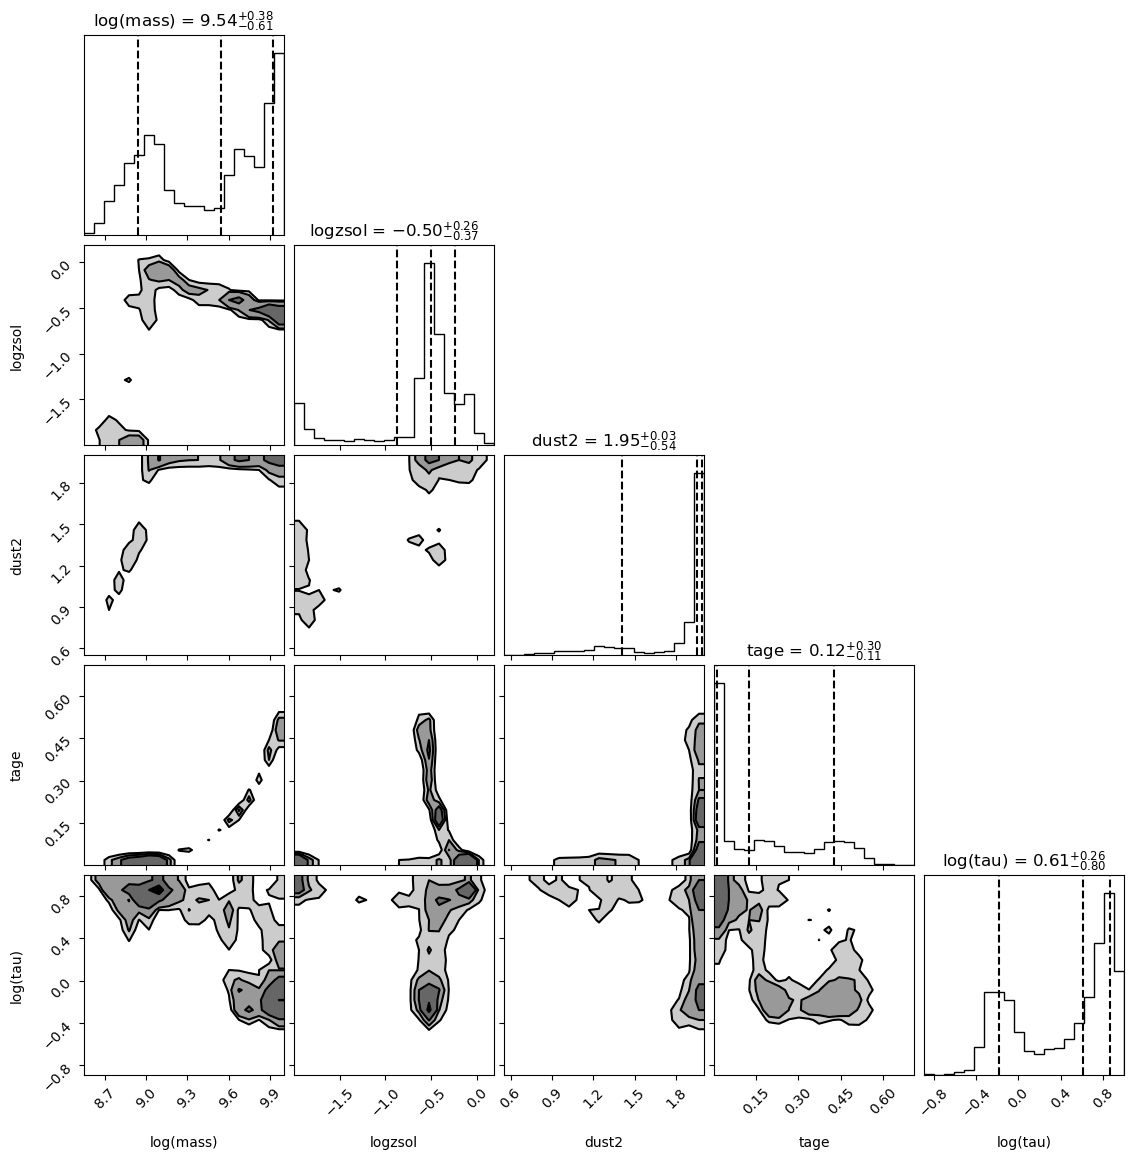

In [13]:
# Trace plots
tfig = reader.traceplot(result)
# Corner figure of posterior PDFs
cfig = reader.subcorner(result)


In [14]:
# Maximum posterior probability sample
imax = np.argmax(result['lnprobability'])
csz = result["chain"].shape
if result["chain"].ndim > 2:
    # emcee
    i, j = np.unravel_index(imax, result['lnprobability'].shape)
    theta_max = result['chain'][i, j, :].copy()
    flatchain = result["chain"].reshape(csz[0] * csz[1], csz[2])
else:
    # dynesty
    theta_max = result['chain'][imax, :].copy()
    flatchain = result["chain"]

# 16th, 50th, and 84th percentiles of the posterior
from prospect.plotting.corner import quantile
weights = result.get("weights", None)
post_pcts = quantile(flatchain.T, q=[0.16, 0.50, 0.84], weights=weights)

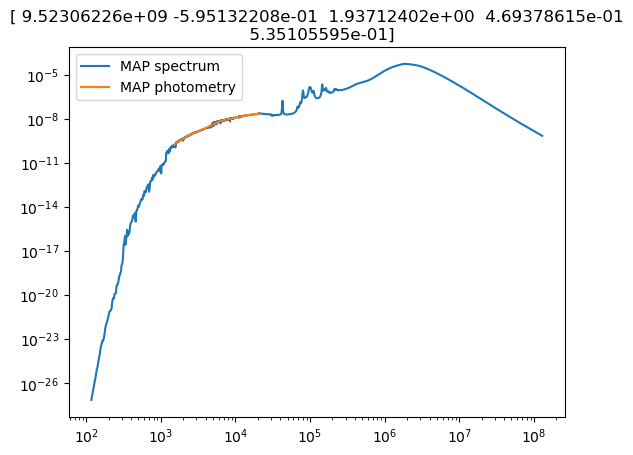

In [43]:
# Plot the stored maximum ln-probability sample
import matplotlib.pyplot as pl

best = result["bestfit"]
a = model.params["zred"] + 1
pl.plot(a * best["restframe_wavelengths"], best['spectrum'], label="MAP spectrum")
if obs['filters'] is not None:
    pwave = [f.wave_effective for f in obs["filters"]]
    pl.loglog(pwave, best['photometry'], label="MAP photometry")
    pl.title(best["parameter"])
pl.legend()


In [18]:
best

{'parameter': array([ 9.52306226e+09, -5.95132208e-01,  1.93712402e+00,  4.69378615e-01,
         5.35105595e-01]),
 'photometry': array([1.71963878e-10, 6.67852146e-10, 1.73315903e-09, 3.43759838e-09,
        6.68727687e-09, 8.49462844e-09, 1.01173718e-08, 1.53130046e-08,
        1.86444820e-08, 2.21252549e-08]),
 'restframe_wavelengths': array([9.100e+01, 9.400e+01, 9.600e+01, ..., 9.817e+07, 9.908e+07,
        1.000e+08]),
 'spectrum': array([7.20531924e-28, 1.70154254e-27, 3.15262543e-27, ...,
        7.15180932e-10, 6.96257916e-10, 6.78303029e-10]),
 'mfrac': 0.7747327394600355}

## Making a corner plot
Our samples more generally can be shown using a corner/triangle plot.  The `subtriangle()` method below is a very thin wrapper on Dan Foreman-Mackey's **corner.py** code.  We'll overplot the MAP value as blue lines.

In [20]:
#ind_best = np.argmin([r.cost for r in result])
#print(ind_best)
theta_best = best['parameter']
print(theta_best)

# generate model
prediction = model.mean_model(theta_best, obs=obs, sps=sps)
pspec, pphot, pfrac = prediction


[ 9.52306226e+09 -5.95132208e-01  1.93712402e+00  4.69378615e-01
  5.35105595e-01]


MAP value: [ 9.52306226e+09 -5.95132208e-01  1.93712402e+00  4.69378615e-01
  5.35105595e-01]


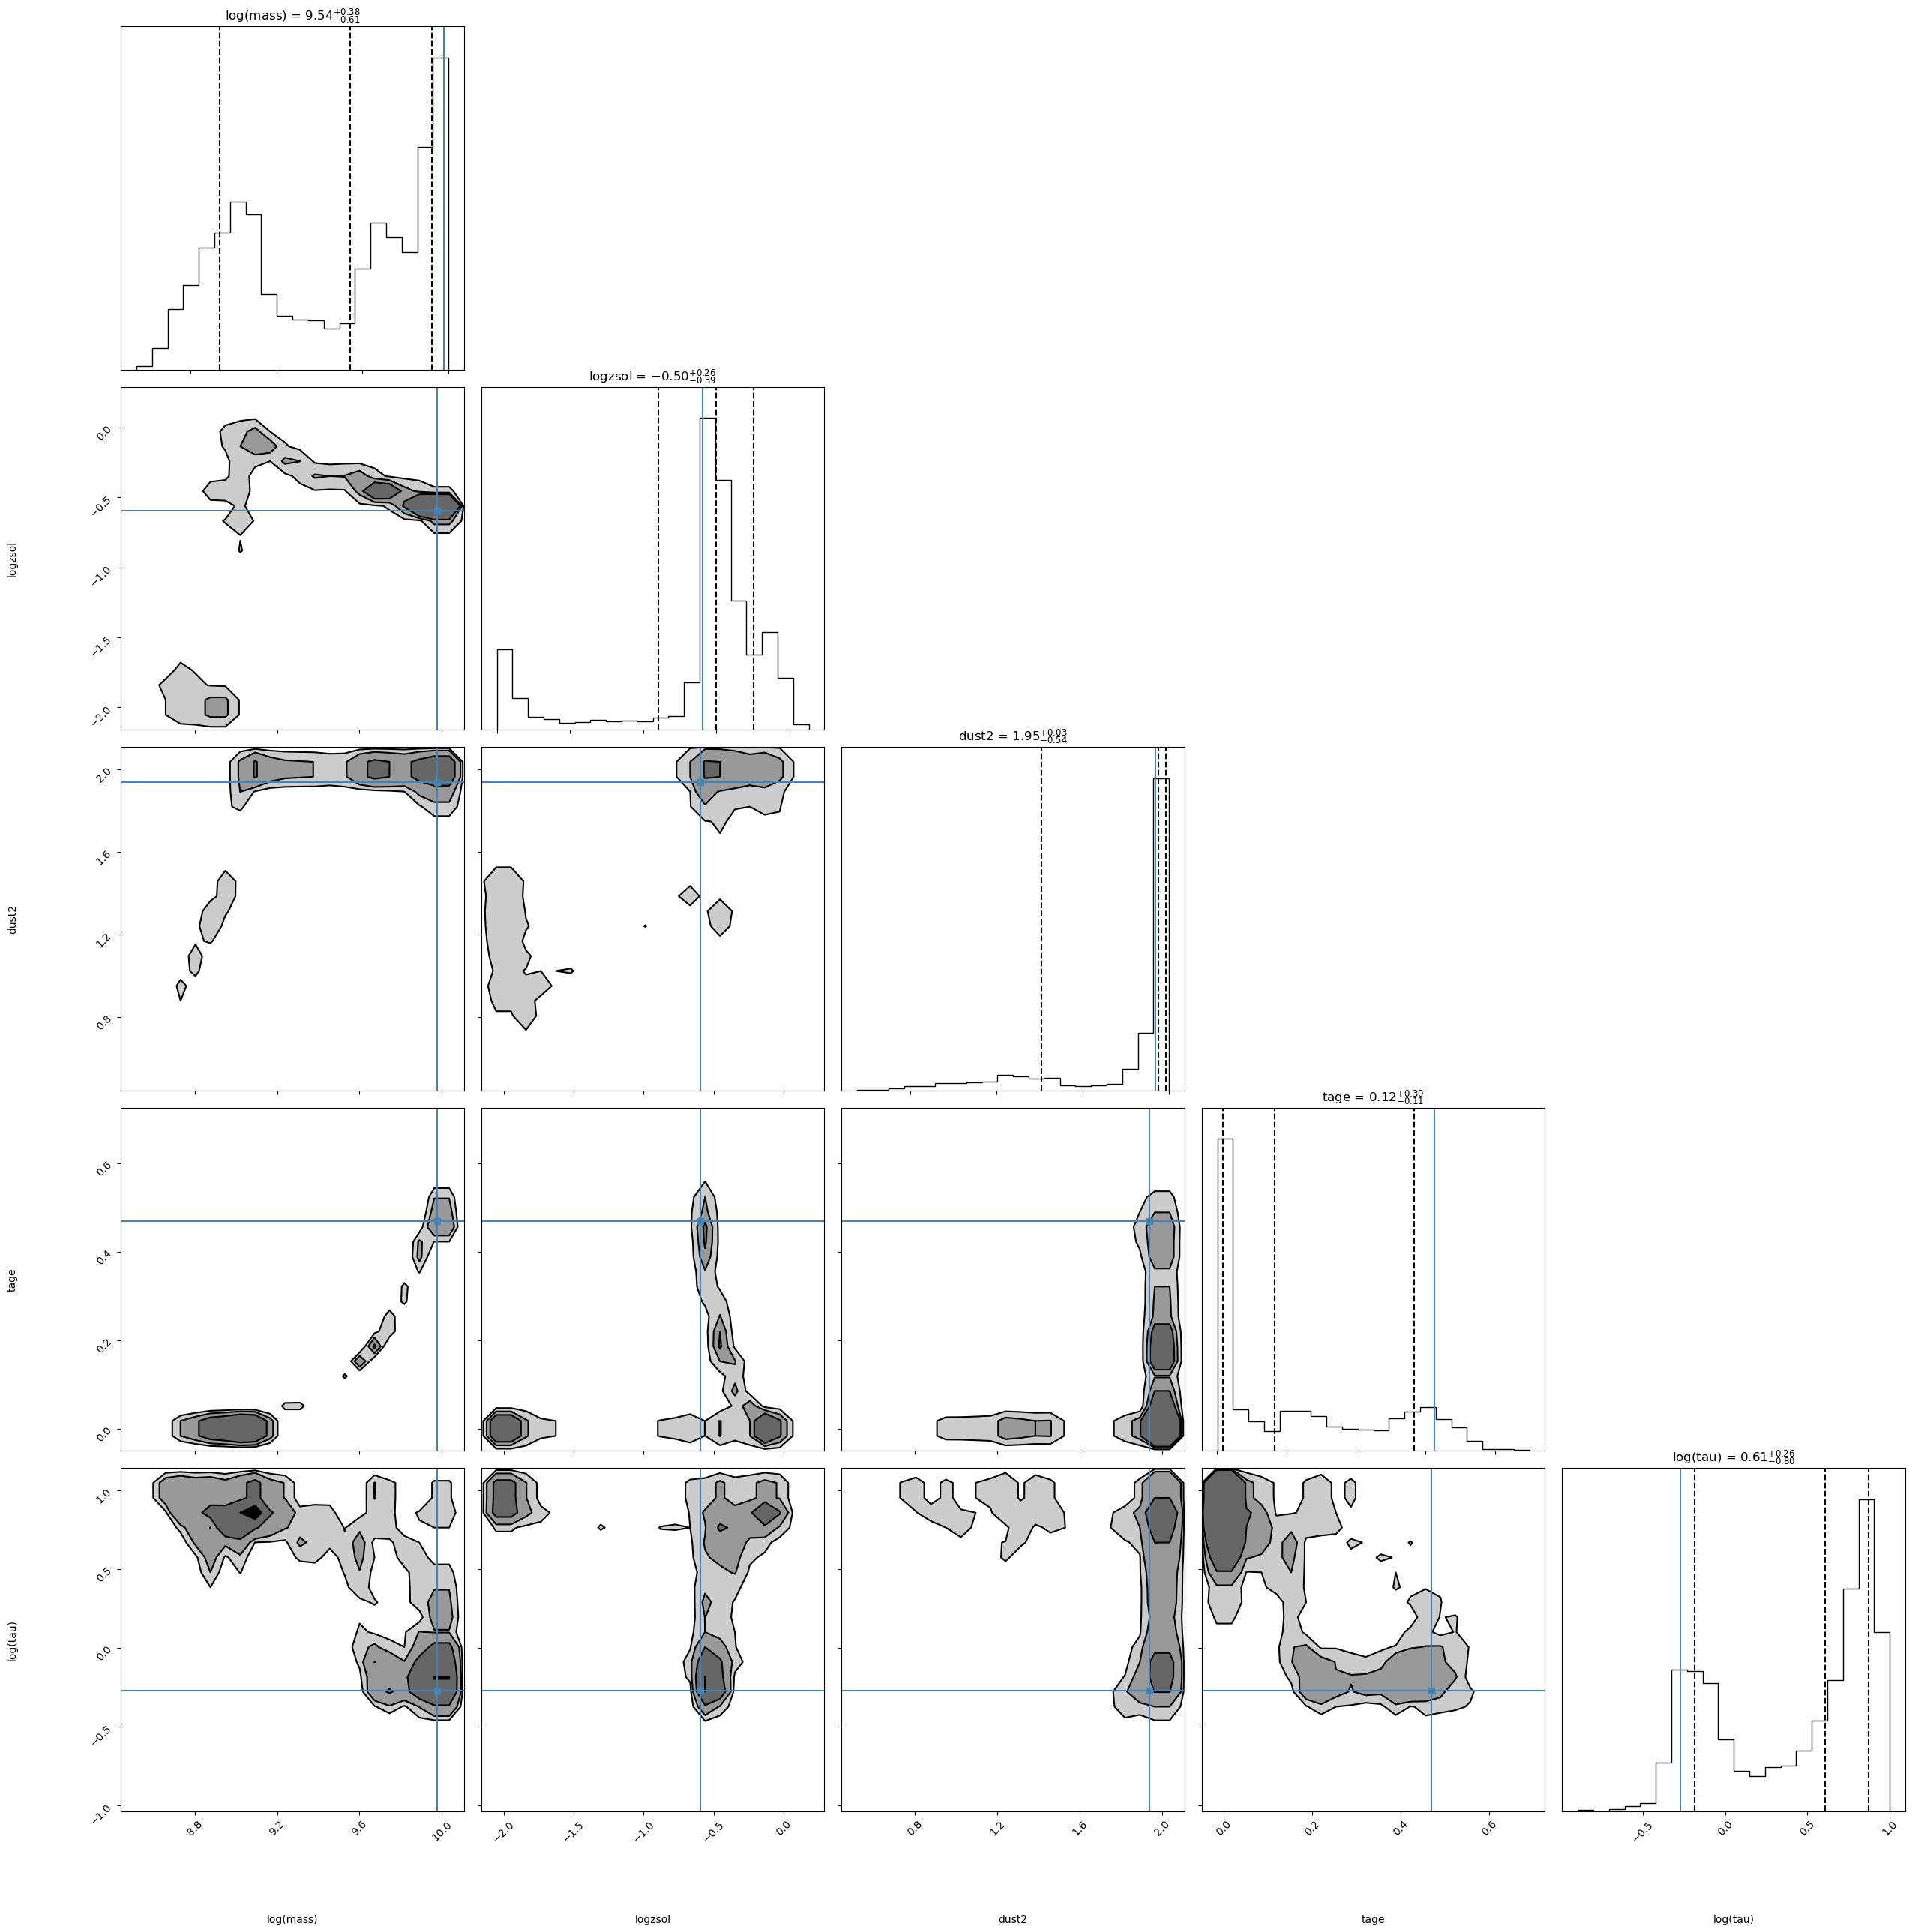

In [23]:
# maximum a posteriori (of the locations visited by the MCMC sampler)
imax = np.argmax(result['lnprobability'])
if results_type == "emcee":
    i, j = np.unravel_index(imax, result['lnprobability'].shape)
    theta_max = result['chain'][i, j, :].copy()
    thin = 5
else:
    theta_max = result["chain"][imax, :]
    thin = 1

#print('Optimization value: {}'.format(theta_best))
print('MAP value: {}'.format(theta_max))
cornerfig = reader.subcorner(result, start=0, thin=thin, truths=theta_best, 
                             fig=pl.subplots(5,5,figsize=(27,27))[0])

## Look at SEDs and residuals
Finally, let's just take a look at a random model drawn from our chains, and at the highest posterior probability model in the chain.  In this notebook we already have the `sps` object instantiated, but in general we may have to regenerate it based on information stored in the output file using the `prospect.io.read_results.get_sps` method.

In [31]:
obs = result["obs"]
obs

{'maggies': array([           nan, 1.49604646e-09, 1.55013190e-09, 3.49224379e-09,
        6.61230588e-09, 8.14539825e-09, 1.22918041e-08, 1.44810285e-08,
        1.75149834e-08, 2.16001434e-08]),
 'maggies_unc': array([           nan, 7.24064269e-10, 1.39130093e-10, 3.64261011e-11,
        3.80695052e-11, 1.67930627e-10, 1.82737274e-10, 2.87499575e-10,
        5.88718997e-10, 6.82949180e-10]),
 'phot_mask': array([False,  True,  True,  True,  True,  True,  True,  True,  True,
         True]),
 'phot_wave': array([ 1528.05975153,  2271.12579359,  3546.00063828,  4669.59393552,
         6155.68605117,  7471.57138923,  8766.25131235, 12504.97216854,
        16388.56221018, 21452.83223588]),
 'filternames': ['galex_FUV',
  'galex_NUV',
  'sdss_u0',
  'sdss_g0',
  'sdss_r0',
  'sdss_i0',
  'vista_vircam_Z',
  'vista_vircam_J',
  'vista_vircam_H',
  'vista_vircam_Ks'],
 'filters': [<class 'sedpy.observate.Filter'>(galex_FUV),
  <class 'sedpy.observate.Filter'>(galex_NUV),
  <class 'sedpy.ob

In [32]:
a = 1.0 + model.params.get('zred', 0.0) # cosmological redshifting
# photometric effective wavelengths
wphot = obs["phot_wave"]
# spectroscopic wavelengths
if obs["wavelength"] is None:
    # *restframe* spectral wavelengths, since obs["wavelength"] is None
    wspec = sps.wavelengths
    wspec *= a #redshift them
else:
    wspec = obs["wavelength"]

In [35]:
wspec.shape

(5994,)

In [36]:
wphot.shape

(10,)

In [26]:
run_params = result["run_params"]
run_params

{'verbose': 1,
 'debug': False,
 'outfile': 'run_optimize_emcee',
 'output_pickle': False,
 'zcontinuous': 1,
 'optimize': True,
 'min_method': 'lm',
 'min_opts': {'x_scale': 'jac'},
 'nmin': 1,
 'emcee': True,
 'nwalkers': 64,
 'niter': 512,
 'nburn': [16, 32, 64],
 'interval': 0.2,
 'restart_from': '',
 'initial_disp': 0.1,
 'dynesty': False,
 'nested_bound': 'multi',
 'nested_sample': 'slice',
 'nested_walks': 48,
 'nested_nlive_init': 100,
 'nested_nlive_batch': 100,
 'nested_dlogz_init': 0.05,
 'nested_maxcall': 50000000,
 'nested_maxiter': 1000000,
 'nested_maxbatch': 10,
 'nested_bootstrap': 0,
 'nested_target_n_effective': 10000,
 'object_redshift': 0.29266,
 'add_neb': False,
 'add_duste': False,
 'inputfile': '../../../../QueryCatalogs/data/FORS2spectraGalexKidsPhotom.hdf5',
 'objid': 214,
 'datamode': 'photom',
 'specnsigs': 3.0,
 'object_number': 214,
 'object_name': 'SPEC214',
 'input_file': '../../../../QueryCatalogs/data/FORS2spectraGalexKidsPhotom.hdf5',
 'specnsig': 3.

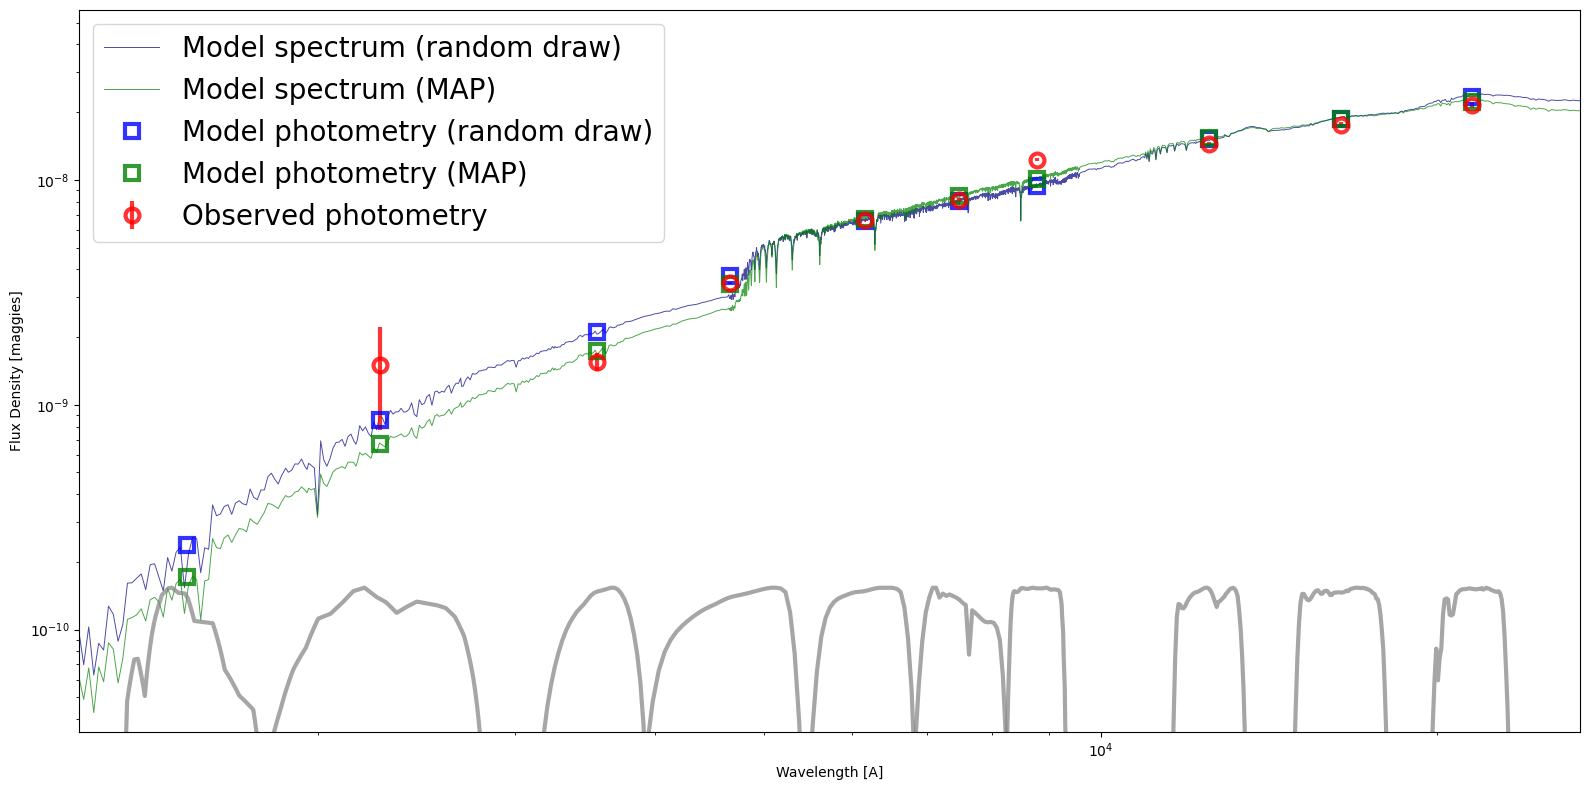

In [41]:
import matplotlib.pyplot as plt

# randomly chosen parameters from chain
randint = np.random.randint
if results_type == "emcee":
    nwalkers, niter = run_params['nwalkers'], run_params['niter']
    theta = result['chain'][randint(nwalkers), randint(niter)]
else:
    theta = result["chain"][randint(len(result["chain"]))]

# generate models
# sps = reader.get_sps(result)  # this works if using parameter files
mspec, mphot, mextra = model.mean_model(theta, obs, sps=sps)
mspec_map, mphot_map, _ = model.mean_model(theta_max, obs, sps=sps)


# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
temp = np.interp(np.linspace(xmin,xmax,10000), wspec, mspec_map)
ymin, ymax = temp.min()*0.8, temp.max()/0.4

# Make plot of data and model
plt.figure(figsize=(16,8))

plt.loglog(wspec, mspec, label='Model spectrum (random draw)',
       lw=0.7, color='navy', alpha=0.7)
plt.loglog(wspec, mspec_map, label='Model spectrum (MAP)',
       lw=0.7, color='green', alpha=0.7)
plt.errorbar(wphot, mphot, label='Model photometry (random draw)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
plt.errorbar(wphot, mphot_map, label='Model photometry (MAP)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='green', 
         markeredgewidth=3)
plt.errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

# plot transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    plt.loglog(w, t, lw=3, color='gray', alpha=0.7)

plt.xlabel('Wavelength [A]')
plt.ylabel('Flux Density [maggies]')
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.legend(loc='best', fontsize=20)
plt.tight_layout()